In [1]:
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import numpy_groupies as npg
import pandas as pd
import scipy.stats as s
import scipy.special as ss
import sortedcontainers as sc
import os

In [2]:
import tqdm

In [3]:
os.environ["CAPY_REF_FA"] = "/home/opriebe/data/ref/hg19/Homo_sapiens_assembly19.fasta"
import hapaseg.coverage_MCMC as mcmc_cov
from capy import mut, seq

Cannot find path to gnomAD index; gnomAD functionality disabled.


Load MCMC trace over SNP DP cluster assignments. Still looking at only the high purity exome

In [4]:
colors = mpl.cm.get_cmap("tab10").colors

### Load coverage

In [5]:
Cov = pd.read_csv("exome/6_C1D1_META.cov", sep = "\t", names = ["chr", "start", "end", "covcorr", "covraw"], low_memory=False)
Cov["chr"] = mut.convert_chr(Cov["chr"])
Cov = Cov.loc[Cov["chr"] != 0]
Cov["start_g"] = seq.chrpos2gpos(Cov["chr"], Cov["start"])
Cov["end_g"] = seq.chrpos2gpos(Cov["chr"], Cov["end"])

### Load covariates

In [6]:
Cov["C_len"] = Cov["end"] - Cov["start"] + 1

# load repl timing
F = pd.read_pickle("covars/GSE137764_H1.hg19_liftover.pickle")

# map targets to RT intervals
tidx = mut.map_mutations_to_targets(Cov.rename(columns = { "start" : "pos" }), F, inplace = False)
Cov.loc[tidx.index, "C_RT"] = F.iloc[tidx, 3:].mean(1).values

# z-transform
Cov["C_RT_z"] = (lambda x : (x - np.nanmean(x))/np.nanstd(x))(np.log(Cov["C_RT"] + 1e-20))

#load GC content
B = pd.read_pickle("covars/GC.pickle")
Cov = Cov.merge(B.rename(columns = { "gc" : "C_GC" }), left_on = ["chr", "start", "end"], right_on = ["chr", "start", "end"], how = "left")
Cov["C_GC_z"] = (lambda x : (x - np.nanmean(x))/np.nanstd(x))(np.log(Cov["C_GC"] + 1e-20))

In [7]:
clust = np.load("exome/6_C1D1_META.DP_clusts.auto_ref_correct.overdispersion92.no_phase_correct.npz")

#### Load chromosome boundary coordinates

In [11]:
allelic_segs = pd.read_pickle("exome/6_C1D1_META.allelic_segs.auto_ref_correct.overdispersion92.no_phase_correct.pickle")
chrbdy = allelic_segs.dropna().loc[:, ["start", "end"]]
chr_ends = chrbdy.loc[chrbdy["start"] != 0, "end"].cumsum()

In [13]:
clust["snps_to_clusters"].shape

(500, 11768)

In [15]:
SNPs = pd.read_pickle("exome/6_C1D1_META.SNPs.pickle")
SNPs["chr"], SNPs["pos"] = seq.gpos2chrpos(SNPs["gpos"])

SNPs["tidx"] = mut.map_mutations_to_targets(SNPs, Cov, inplace = False)

#generate unique clust assignments
clust_u, clust_uj = np.unique(clust["snps_to_clusters"], return_inverse = True)
clust_uj = clust_uj.reshape(clust["snps_to_clusters"].shape)

### load SNPs from single DP iteration

In [24]:
iter_ind = 499
SNPs = pd.read_pickle("exome/6_C1D1_META.SNPs.pickle")
SNPs["chr"], SNPs["pos"] = seq.gpos2chrpos(SNPs["gpos"])

SNPs["tidx"] = mut.map_mutations_to_targets(SNPs, Cov, inplace = False)

#generate unique clust assignments
clust_u, clust_uj = np.unique(clust["snps_to_clusters"], return_inverse = True)
clust_uj = clust_uj.reshape(clust["snps_to_clusters"].shape)

#assign coverage intervals to clusters
Cov_clust_probs = np.zeros([len(Cov), clust_u.max()])

for targ, snp_idx in SNPs.groupby("tidx").indices.items():
    targ_clust_hist = np.bincount(clust_uj[499, snp_idx].ravel(), minlength = clust_u.max())

    Cov_clust_probs[int(targ), :] = targ_clust_hist/targ_clust_hist.sum()

#subset intervals containing SNPs
overlap_idx = Cov_clust_probs.sum(1) > 0
Cov_clust_probs_overlap = Cov_clust_probs[overlap_idx, :]

#prune improbable assignments
Cov_clust_probs_overlap[Cov_clust_probs_overlap < 0.05] = 0
Cov_clust_probs_overlap /= Cov_clust_probs_overlap.sum(1)[:, None]
prune_idx = Cov_clust_probs_overlap.sum(0) > 0
Cov_clust_probs_overlap = Cov_clust_probs_overlap[:, prune_idx]

In [28]:
import scipy.stats

In [43]:
assgn_entropy = scipy.stats.entropy(Cov_clust_probs_overlap, axis=1)

(array([8.077e+03, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 1.600e+01,
        6.600e+01, 0.000e+00, 1.000e+00, 3.000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

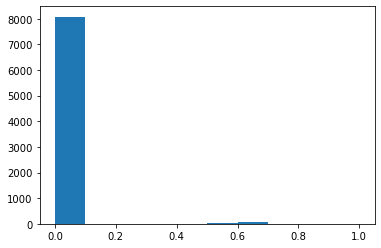

In [41]:
plt.hist(scipy.stats.entropy(Cov_clust_probs_overlap, axis=1), bins = np.r_[0:1.1:0.1], density=False)

almost all bins are unanimously assigned

In [44]:
entropy_idx = (assgn_entropy == 0)

In [51]:
Cov_overlap.shape

(8184, 12)

In [57]:
#subsetting to only targets that overlap SNPs
Cov_overlap = Cov.loc[overlap_idx, :]

#subsetting to only targets with hard assignments
Cov_overlap = Cov_overlap.loc[entropy_idx,:]

r = np.c_[Cov_overlap["covcorr"]]

#making covariate matrix
C = np.c_[np.log(Cov_overlap["C_len"]), Cov_overlap["C_RT_z"], Cov_overlap["C_GC_z"]]

Pi = Cov_clust_probs_overlap[entropy_idx,:].copy()

In [59]:
#dropping Nans
naidx = np.isnan(C[:, 1])
r = r[~naidx]
C = C[~naidx]
Pi = Pi[~naidx]

In [60]:
Cov_overlap = Cov_overlap.iloc[~naidx]

In [61]:
Cov_overlap

,chr,start,end,covcorr,covraw,start_g,end_g,C_len,C_RT,C_RT_z,C_GC,C_GC_z
99,1,984246,984439,72279,110383,984246,984439,194,1.079453,1.880682,0.685567,0.269813
135,1,1138970,1139348,185857,281995,1138970,1139348,379,0.909914,0.588950,0.704485,0.291114
142,1,1147321,1147518,78285,120449,1147321,1147518,198,0.909914,0.588950,0.707071,0.293980
344,1,1469305,1469452,36846,57636,1469305,1469452,148,0.870065,0.250387,0.668919,0.250576
514,1,1956956,1957177,69400,108383,1956956,1957177,222,1.002400,1.320789,0.621622,0.193192
...,...,...,...,...,...,...,...,...,...,...,...,...
196523,22,50986595,50988380,977681,1456772,2880715315,2880717100,1786,0.954171,0.948001,0.693729,0.279074
196531,22,51009803,51009968,59148,93244,2880738523,2880738688,166,1.022385,1.470038,0.602410,0.168626
196560,22,51042269,51043492,635932,981591,2880770989,2880772212,1224,1.060847,1.749233,0.744281,0.334114
196569,22,51064006,51064109,40385,64456,2880792726,2880792829,104,1.060847,1.749233,0.576923,0.134799


In [65]:
Pi.shape

(8044, 19)

In [69]:
Cov_overlap['cluster_assgn'] = np.argmax(Pi, axis=1)

In [62]:
mcmc_C = mcmc_cov.Cov_MCMC(r, C, Pi, Cov_overlap)

In [63]:
mcmc_C.NR_simp()

In [70]:
residuals = np.exp(np.log(mcmc_C.r) - (mcmc_C.Pi@mcmc_C.mu) - mcmc_C.C@mcmc_C.beta)

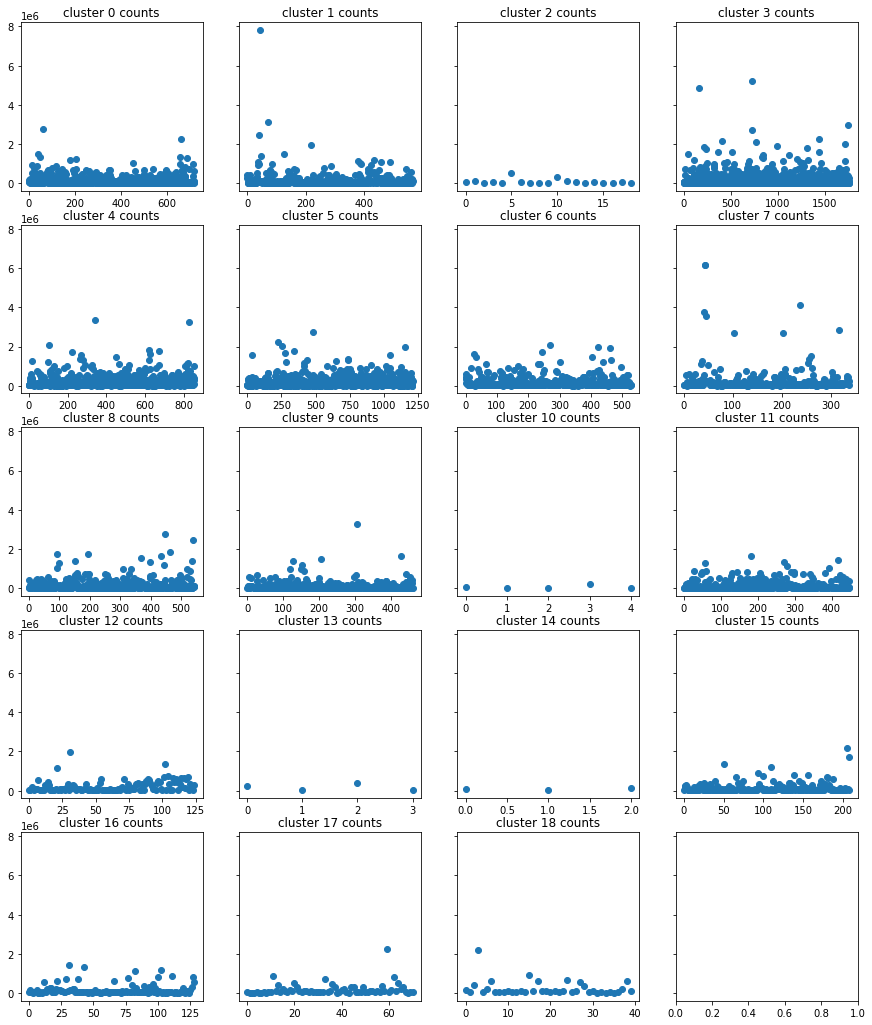

In [101]:
fig , axs = plt.subplots(5,4, figsize = (15,18), sharey=True)
ax_lst = axs.flatten()
for targ, cov_idx in Cov_overlap.groupby("cluster_assgn").indices.items():
    ax_lst[targ].scatter(np.r_[:len(cov_idx)], r[cov_idx])
    ax_lst[targ].set_title('cluster {} counts'.format(targ))

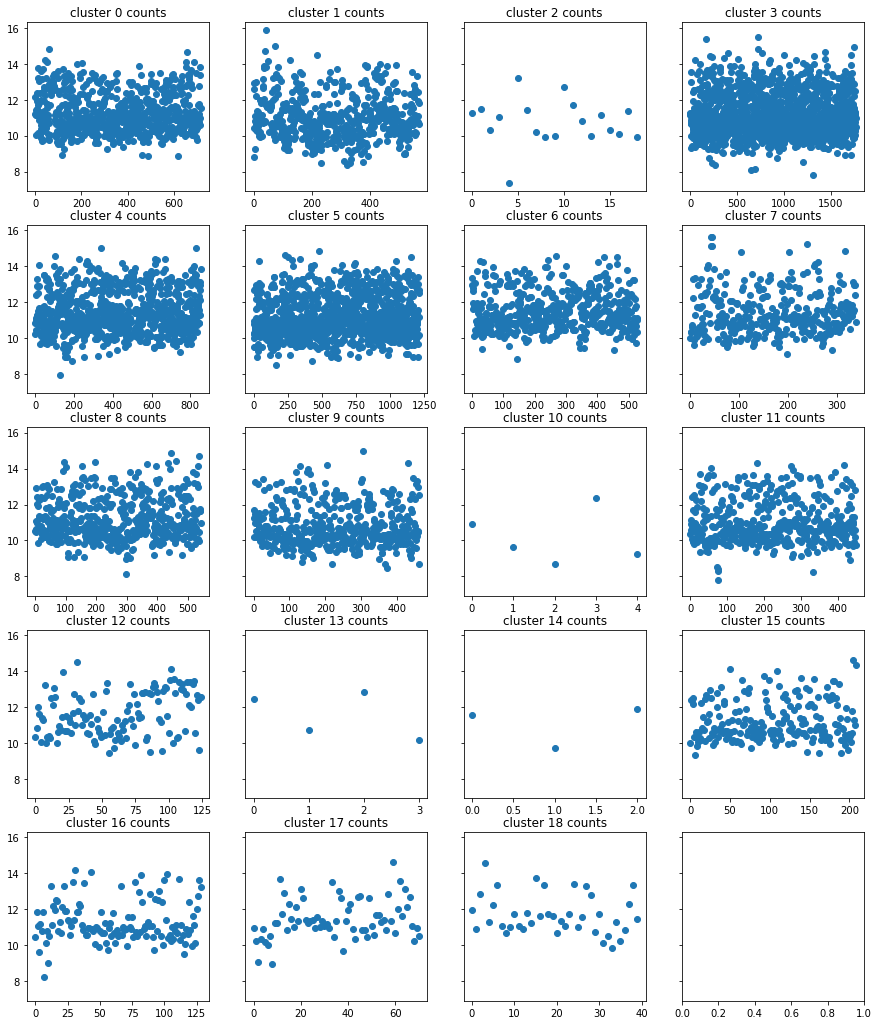

In [102]:
fig , axs = plt.subplots(5,4, figsize = (15,18), sharey=True)
ax_lst = axs.flatten()
for targ, cov_idx in Cov_overlap.groupby("cluster_assgn").indices.items():
    ax_lst[targ].scatter(np.r_[:len(cov_idx)], np.log(r[cov_idx]))
    ax_lst[targ].set_title('cluster {} counts'.format(targ))

In [ ]:
means = []
variances = []
for targ, cov_idx in Cov_overlap.groupby("cluster_assgn").indices.items():
    mean = r[cov_idx].mean()
    means.append(mean)
    var = np.mean((r[cov_idx] - mean)**2)
    variances.append(var)

In [ ]:
np.array(means)/np.array(variances)

array([2.62601872e-06, 8.61575912e-07, 5.42196201e-06, 1.57375160e-06,
       2.00377294e-06, 2.50771116e-06, 2.38877137e-06, 5.74486712e-07,
       1.89021369e-06, 1.94825570e-06, 8.71897107e-06, 2.67740173e-06,
       2.68615443e-06, 8.38363809e-06, 3.05765453e-05, 2.21620550e-06,
       2.32725771e-06, 1.97554467e-06, 1.65531977e-06])

In [ ]:
list(zip(means, variances))

[(155046.16713091923, 59042293168.807724),
 (153510.15316901408, 178173682748.96777),
 (91325.21052631579, 16843572569.639887),
 (143173.47535410765, 90975904426.2392),
 (188537.4531615925, 94091226317.85202),
 (144471.60858794386, 57610944446.373634),
 (185826.07939508508, 77791487911.91808),
 (250138.66076696166, 435412439317.8702),
 (162792.04227941178, 86123618210.103),
 (109792.22943722944, 56354116859.423546),
 (63362.6, 7267210719.839999),
 (139115.5723830735, 51959170355.02427),
 (219056.392, 81550185518.43034),
 (175097.75, 20885652283.1875),
 (89721.0, 2934307954.6666665),
 (158376.15311004786, 71462755943.4311),
 (172644.60465116278, 74183707264.51811),
 (184142.4084507042, 93210956591.11485),
 (242669.4, 146599710930.28998)]

In [111]:
(155046.16713091923**2) / (59042293168.807724 - 155046.16713091923)

0.40715520654172754

In [114]:
59042293168.807724 - (155046.16713091923 + 155046.16713091923**2 /0.40715520654172754)

0.0

In [640]:
mu = mu_0.copy()
epsi = 6

In [115]:
np.log(0.4)

-0.916290731874155

In [536]:
cl1_mask = Cov_overlap['cluster_assgn']==0
r = r[cl1_mask]
C = C[cl1_mask]
Pi = Pi[cl1_mask]
beta = beta_0.copy()

In [641]:
beta = beta_0.copy()

Welp! lots of overdispersion (factor of 1E6 for most clusters!)

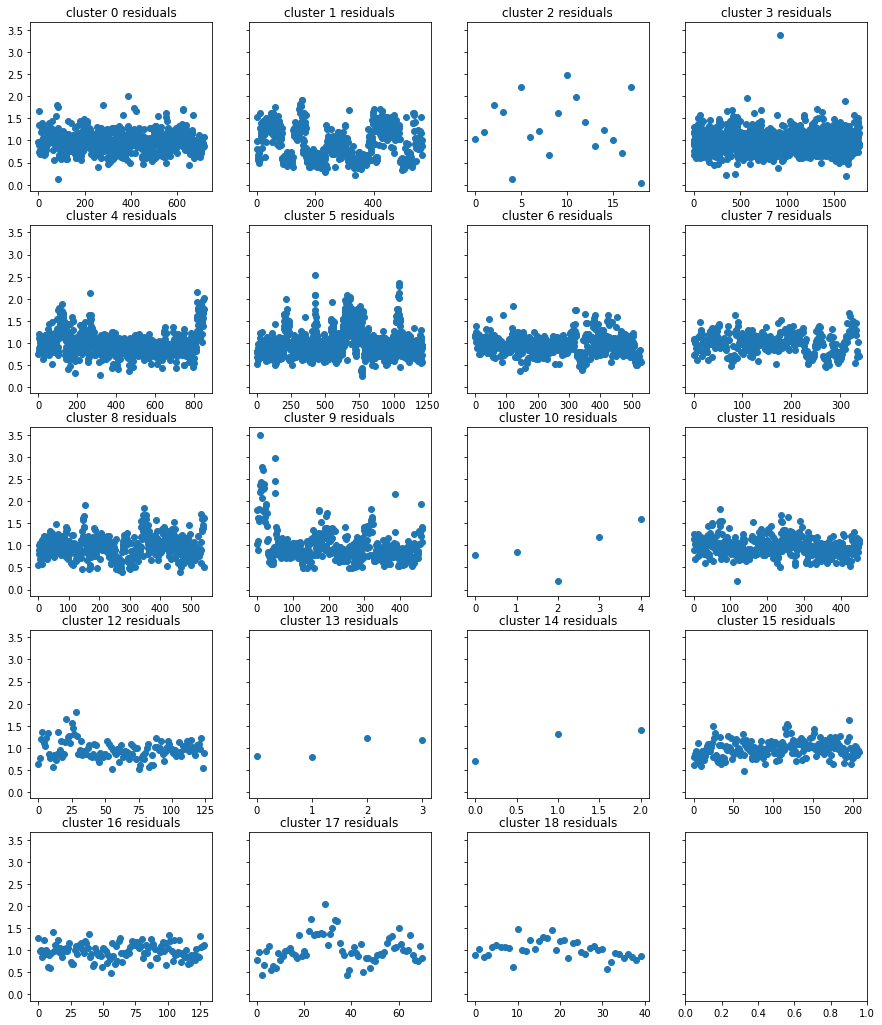

In [ ]:
fig , axs = plt.subplots(5,4, figsize = (15,18), sharey=True)
ax_lst = axs.flatten()
for targ, cov_idx in Cov_overlap.groupby("cluster_assgn").indices.items():
    ax_lst[targ].scatter(np.r_[:len(cov_idx)], residuals[cov_idx])
    ax_lst[targ].set_title('cluster {} residuals'.format(targ))

Despite this there seems to be signs of clear TCR changes when we look at the residuals of each cluster